In [1]:
linear_probe = "/nethome/bdevnani3/flash1/long_tail_lang/results_sklearn/config_image_linear_probe_0/13-Sep-2022-12-10-03/final_model.sav"

In [2]:
import pickle
import numpy as np
import torch
from utils import *
from tqdm.notebook import trange, tqdm
import random
import json
import pandas as pd

In [3]:
# Load Test Data

image_embeddings = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/image_embeddings.pt").cpu()
labels = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/labels.pt").cpu()


In [4]:
from classes import CLASSES, GENERIC_PROMPT_COLLECTIONS
import torch.nn as nn
from clip import clip
import os
import torch


# Initialize CLIP models 
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype
        self.token_embedding = clip_model.token_embedding

    def forward(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

def load_clip_to_cpu(visual_backbone):
    backbone_name = visual_backbone
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url, os.path.expanduser("~/.cache/clip"))

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())

    return model

clip_model = load_clip_to_cpu("RN50")

visual_model = torch.nn.DataParallel(clip_model.visual).cuda()

text_model = TextEncoder(clip_model)
text_model = torch.nn.DataParallel(text_model).cuda()

In [5]:
all_labels_text = {}
text_embs = []
text_labels = []
with torch.no_grad():
    for label in tqdm(range(1000)):
        all_labels_text[label] = []

        templates = ["a photo of a {}."]
        c = np.array(CLASSES)[label]
            
        texts = clip.tokenize([template.format(c) for template in templates]) 
        texts = texts.cuda()
        zeroshot_weights = clip_model.encode_text(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )
        all_labels_text[label].append(zeroshot_weights)
        text_embs.append(zeroshot_weights)
        for i in range(len(templates)):
            text_labels.append(label)
        
text_embs = torch.cat(text_embs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
# Class frequencies

freqs = json.load(open("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/class_frequencies.json"))
freqs = {int(k):v for k,v in freqs.items()}
freqs

{91: 81,
 129: 161,
 683: 77,
 830: 343,
 450: 48,
 593: 292,
 566: 1173,
 600: 169,
 86: 1280,
 559: 310,
 83: 135,
 104: 61,
 466: 152,
 335: 109,
 367: 128,
 773: 175,
 52: 189,
 3: 352,
 347: 198,
 616: 354,
 387: 231,
 658: 253,
 486: 127,
 984: 714,
 947: 284,
 571: 340,
 907: 216,
 262: 102,
 828: 229,
 684: 42,
 417: 1053,
 490: 652,
 601: 683,
 879: 134,
 309: 306,
 81: 93,
 585: 101,
 236: 29,
 31: 83,
 770: 129,
 987: 233,
 191: 244,
 395: 26,
 637: 100,
 870: 642,
 715: 194,
 112: 393,
 2: 516,
 363: 169,
 388: 171,
 97: 819,
 737: 472,
 899: 272,
 929: 534,
 844: 175,
 922: 284,
 375: 232,
 979: 98,
 23: 171,
 499: 22,
 319: 290,
 209: 43,
 228: 41,
 765: 290,
 913: 215,
 725: 454,
 291: 53,
 33: 56,
 787: 271,
 318: 611,
 783: 229,
 970: 72,
 680: 61,
 875: 459,
 464: 224,
 365: 158,
 934: 141,
 628: 140,
 631: 57,
 554: 382,
 30: 287,
 451: 137,
 956: 80,
 134: 285,
 638: 90,
 107: 133,
 449: 236,
 194: 106,
 578: 252,
 75: 58,
 744: 56,
 978: 217,
 687: 264,
 976: 625,


In [7]:
clf_lp = pickle.load(open(linear_probe, 'rb'))
clf_lp2 = pickle.load(open("/nethome/bdevnani3/flash1/long_tail_lang/results_sklearn/config_image_linear_probe_0/13-Sep-2022-01-17-05/final_model.sav", 'rb'))
clf_convex_comb = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
clf_convex_comb_culp = pickle.load(open("results_sklearn/config_convex_comb_culp_1/14-Sep-2022-01-30-54/final_model.sav", 'rb'))


### Linear Probe

In [112]:
predictions = clf_lp.predict(image_embeddings)
avg_acc = mic_acc_cal(predictions, labels.numpy())
avg_acc

0.56098

In [113]:
prediction_frequency = np.zeros((1,1000))[0,:]
for p in predictions:
    prediction_frequency[p] +=1

In [114]:
df_lp = pd.DataFrame.from_dict(freqs, orient='index', columns=['Frequency']).sort_index()
df_lp["Prediction_frequency"] = prediction_frequency
df_lp = df_lp.sort_values(by=["Frequency"])
df_lp = df_lp.reset_index()
df_lp

,index,Frequency,Prediction_frequency
0,356,5,0.0
1,155,5,0.0
2,865,5,3.0
3,747,5,2.0
4,58,5,1.0
...,...,...,...
995,417,1053,132.0
996,333,1121,91.0
997,566,1173,144.0
998,674,1246,239.0


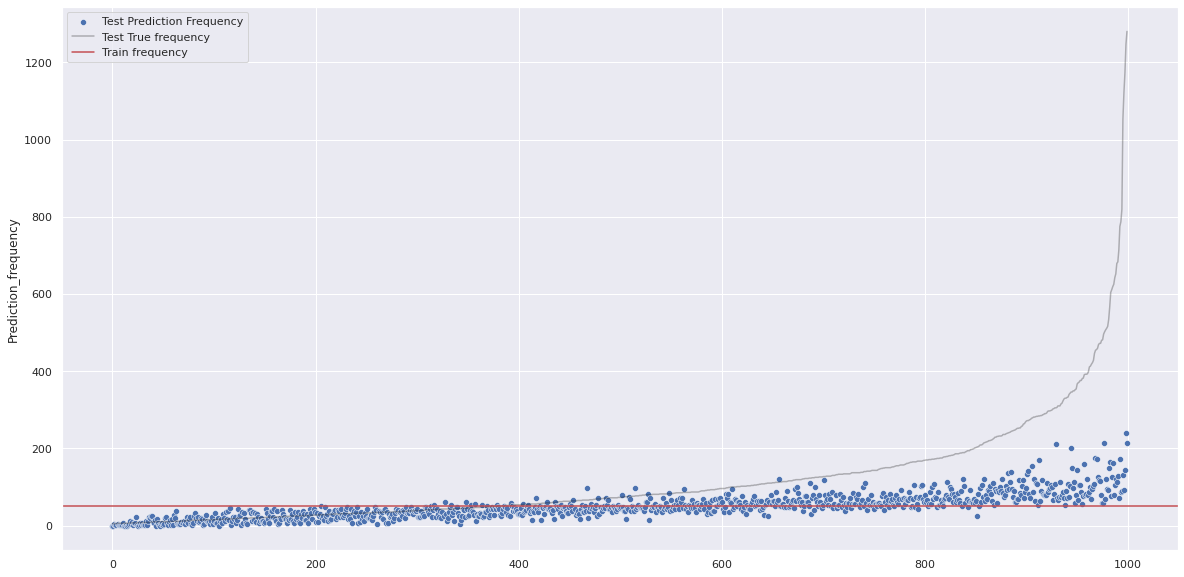

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,10)
graph = sns.scatterplot(data=df_lp, x = df_lp.index, y = "Prediction_frequency")
graph = sns.lineplot(data=df_lp, x = df_lp.index, y = "Frequency", alpha= 0.3, color="k")
graph = graph.axhline(50, c="r")
plt.legend(labels=['Test Prediction Frequency', 'Train frequency', 'Test True frequency'])

### Convex Comb

In [109]:
predictions = clf_convex_comb.predict(image_embeddings)
avg_acc = mic_acc_cal(predictions, labels.numpy())
avg_acc

0.62202

In [110]:
prediction_frequency = np.zeros((1,1000))[0,:]
for p in predictions:
    prediction_frequency[p] +=1
    
df_lp = pd.DataFrame.from_dict(freqs, orient='index', columns=['Frequency']).sort_index()
df_lp["Prediction_frequency"] = prediction_frequency
df_lp = df_lp.sort_values(by=["Frequency"])
df_lp = df_lp.reset_index()

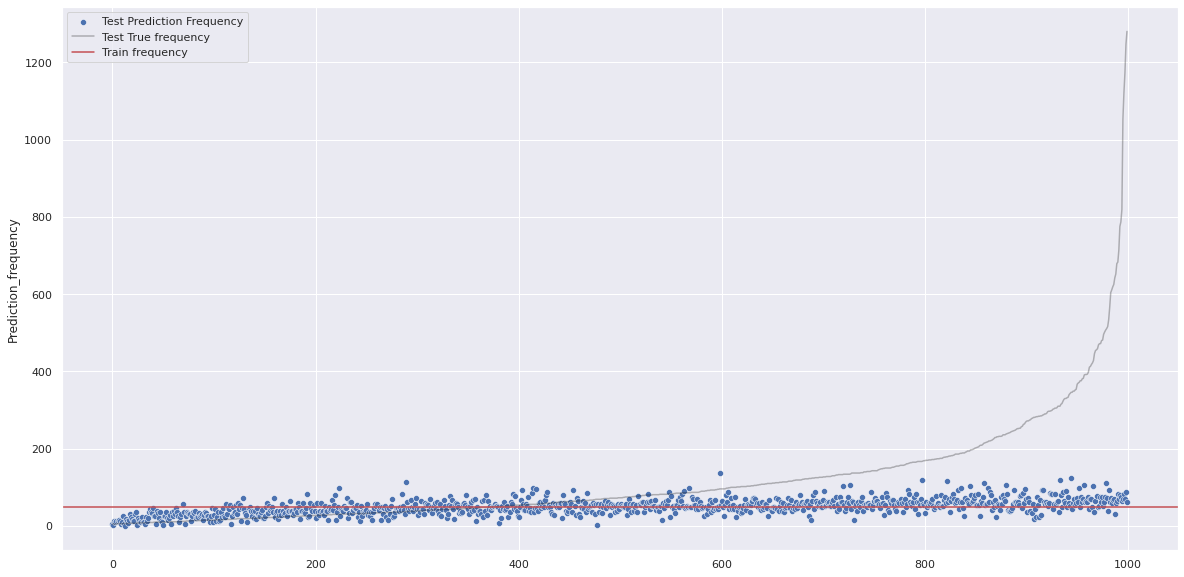

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,10)
graph = sns.scatterplot(data=df_lp, x = df_lp.index, y = "Prediction_frequency")
graph = sns.lineplot(data=df_lp, x = df_lp.index, y = "Frequency", alpha= 0.3, color="k")
graph = graph.axhline(50, c="r")
plt.legend(labels=['Test Prediction Frequency', 'Test True frequency', 'Train frequency'])

### Convex Comb proj

In [106]:
predictions = clf_convex_comb_culp.predict(image_embeddings)
avg_acc = mic_acc_cal(predictions, labels.numpy())
avg_acc

0.61198

In [107]:
prediction_frequency = np.zeros((1,1000))[0,:]
for p in predictions:
    prediction_frequency[p] +=1
    
df_lp = pd.DataFrame.from_dict(freqs, orient='index', columns=['Frequency']).sort_index()
df_lp["Prediction_frequency"] = prediction_frequency
df_lp = df_lp.sort_values(by=["Frequency"])
df_lp = df_lp.reset_index()

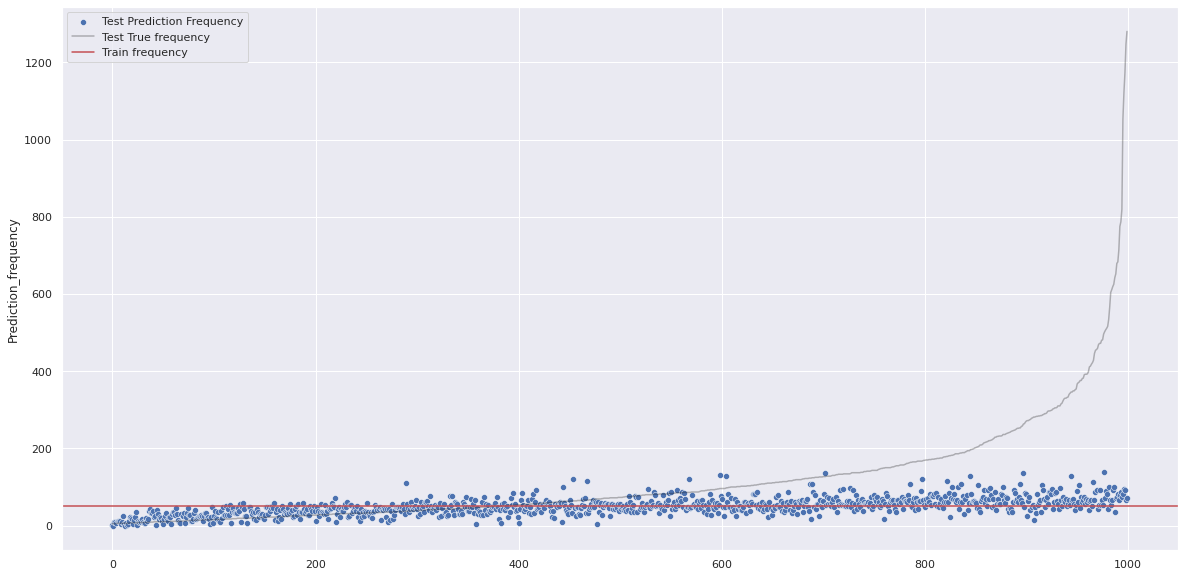

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,10)
graph = sns.scatterplot(data=df_lp, x = df_lp.index, y = "Prediction_frequency")
graph = sns.lineplot(data=df_lp, x = df_lp.index, y = "Frequency", alpha= 0.3, color="k")
graph = graph.axhline(50, c="r")
plt.legend(labels=['Test Prediction Frequency', 'Test True frequency', 'Train frequency'])